# Tiger/Cat Classifier

## Importing Dependencies

In [3]:
from pathlib import Path
from torchinfo import summary
from collections import defaultdict
from tqdm.auto import tqdm

from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import list_models
from torchvision.models import inception_v3, Inception_V3_Weights

import torchvision.transforms as trans

from matplotlib import pyplot as plt

D:\Python Projects For Github\Tiger Classifier\tiger\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## PreProcessing

In [20]:
DATA_PATH_TRAIN = Path("tiger_dataset/train")
DATA_PATH_TEST = Path("tiger_dataset/valid")
DATA_PATH_VAL = Path("tiger_dataset/test")

IMAGE_SIZE = (342, 342)
EPOCHS = 10
LR = 0.01
BATCH_SIZE = 64

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
simple_transform = trans.Compose([
    trans.Resize(IMAGE_SIZE),
    trans.ToTensor(),
    trans.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [22]:
train_data = ImageFolder(DATA_PATH_TRAIN, transform = simple_transform)
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)

eval_data = ImageFolder(DATA_PATH_VAL, transform = simple_transform)
eval_loader = DataLoader(eval_data, batch_size = BATCH_SIZE, shuffle = True)

test_data = ImageFolder(DATA_PATH_TEST, transform = simple_transform)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Before and after transform')

<Figure size 2400x800 with 0 Axes>

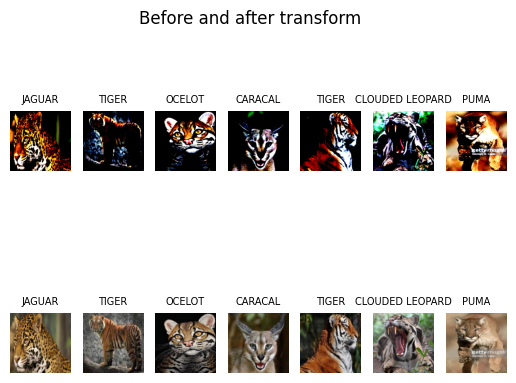

In [8]:
from matplotlib import pyplot as plt
import random
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]



random_samples_idx = random.sample(range(len(train_data)), k=7)


plt.figure(figsize=(24, 8))
fig,ax = plt.subplots(2,7)


for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = train_data[targ_sample][0], train_data[targ_sample][1]

    targ_image_adjust = targ_image.permute(1, 2, 0)

        
    ax[0,i].imshow(targ_image_adjust)
    ax[0,i].axis("off")
    title = f"{train_data.classes[targ_label]}"
    ax[0,i].set_title(title, fontsize = 7)
    
    trans_img = (targ_image_adjust.numpy() * std + mean).clip(0,1)
    ax[1,i].imshow(trans_img)
    ax[1,i].axis("off")
    ax[1,i].set_title(f"{title}",fontsize = 7)
    
fig.suptitle("Before and after transform")

## Model Setup and Fine adjustment

In [16]:
weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights = weights)

In [17]:
# Feature Extractor -- Frozen
for param in model.parameters():
    param.requires_grad = False

# Head/ Classifier -- Trainable
model.fc = nn.Linear(in_features = 2048, out_features = len(train_data.classes))

In [16]:
summary(model = model, input_size = [1, 3, 342, 342],
        col_names = ["input_size", "output_size", "num_params", "trainable"])

D:\Python Projects For Github\Tiger Classifier\tiger\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

D:\Python Projects For Github\Tiger Classifier\tiger\lib\site-packages\torch\storage.py:665: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Inception3                               [1, 3, 342, 342]          [1, 10]                   3,326,696                 Partial
├─BasicConv2d: 1-1                       [1, 3, 342, 342]          [1, 32, 170, 170]         --                        False
│    └─Conv2d: 2-1                       [1, 3, 342, 342]          [1, 32, 170, 170]         (864)                     False
│    └─BatchNorm2d: 2-2                  [1, 32, 170, 170]         [1, 32, 170, 170]         (64)                      False
├─BasicConv2d: 1-2                       [1, 32, 170, 170]         [1, 32, 168, 168]         --                        False
│    └─Conv2d: 2-3                       [1, 32, 170, 170]         [1, 32, 168, 168]         (9,216)                   False
│    └─BatchNorm2d: 2-4                  [1, 32, 168, 168]         [1, 32, 168, 168]         (64)                      

In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

## Training Loop

In [18]:
def train_step(model, loss_fn, optimizer, train_loader, device):
    model.train()
    model = model.to(device)
    running_loss, running_acc = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        y_logits = model(x).logits
        y_probs = torch.argmax(torch.softmax(y_logits, dim = 0), dim = 1)
        
        loss = loss_fn(y_logits, y)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_acc += (y == y_probs).sum().item() / len(y_probs)
    
    running_loss /= len(train_loader)
    running_acc /= len(train_loader)
    
    return running_loss, running_acc

def test_step(model, loss_fn, test_loader, device):
    model.eval()
    model = model.to(device)
    
    running_loss, running_acc = 0, 0
    with torch.inference_mode():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            y_logits = model(x)
            y_probs = torch.argmax(torch.softmax(y_logits, dim = 0), dim = 1)

            loss = loss_fn(y_logits, y)
            running_loss += loss.item()
            running_acc +=(y == y_probs).sum().item() / len(y_probs)

    running_loss /= len(test_loader)
    running_acc /= len(test_loader)
    
    return running_loss, running_acc



def fit(model, loss_fn, optimizer, train_loader, test_loader, epochs, device):
    
    model_results = defaultdict(list)
    for epoch in tqdm(range(epochs)):
        
        running_loss_train, running_acc_train = train_step(model,loss_fn, optimizer, train_loader, device)
        running_loss_test, running_acc_test = test_step(model, loss_fn, test_loader, device)
        
        model_results["train_acc"].append(running_acc_train)
        model_results["test_acc"].append(running_acc_test)
        model_results["train_loss"].append(running_loss_train)
        model_results["test_loss"].append(running_loss_test)
        
        print(f"epoch: {epoch+1} / {epochs}, train_loss: {running_loss_train:.4f} | test_loss: {running_loss_test:.4f} | train_acc: {running_acc_train:.4f} | test_acc: {running_acc_test:.4f}")
        
    return model_results

In [19]:
model_result = fit(model, loss_fn, optimizer, train_loader, test_loader, EPOCHS, DEVICE)

 10%|████████▎                                                                          | 1/10 [00:22<03:26, 22.97s/it]

epoch: 0 / 10, train_loss: 1.4115 | test_loss: 0.4277 | train_acc: 0.7077 | test_acc: 0.8200


 20%|████████████████▌                                                                  | 2/10 [00:43<02:53, 21.63s/it]

epoch: 1 / 10, train_loss: 0.4313 | test_loss: 0.3709 | train_acc: 0.7724 | test_acc: 0.8400


 30%|████████████████████████▉                                                          | 3/10 [01:06<02:36, 22.31s/it]

epoch: 2 / 10, train_loss: 0.4008 | test_loss: 0.3713 | train_acc: 0.8177 | test_acc: 0.8000


 40%|█████████████████████████████████▏                                                 | 4/10 [01:29<02:13, 22.28s/it]

epoch: 3 / 10, train_loss: 0.3672 | test_loss: 0.3708 | train_acc: 0.8099 | test_acc: 0.8200


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:49<01:48, 21.67s/it]

epoch: 4 / 10, train_loss: 0.3393 | test_loss: 0.3546 | train_acc: 0.8239 | test_acc: 0.8200


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:10<01:25, 21.33s/it]

epoch: 5 / 10, train_loss: 0.3927 | test_loss: 0.5762 | train_acc: 0.7908 | test_acc: 0.8600


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:31<01:03, 21.13s/it]

epoch: 6 / 10, train_loss: 0.3290 | test_loss: 0.3689 | train_acc: 0.8418 | test_acc: 0.7800


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:51<00:41, 20.95s/it]

epoch: 7 / 10, train_loss: 0.3220 | test_loss: 0.5291 | train_acc: 0.8326 | test_acc: 0.8200


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:12<00:20, 20.94s/it]

epoch: 8 / 10, train_loss: 0.3141 | test_loss: 0.3773 | train_acc: 0.8116 | test_acc: 0.8000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:33<00:00, 21.37s/it]

epoch: 9 / 10, train_loss: 0.3306 | test_loss: 0.4593 | train_acc: 0.8165 | test_acc: 0.8400


## Plot Metrics

Text(0.5, 0.98, 'LOSS & ACCURACY')

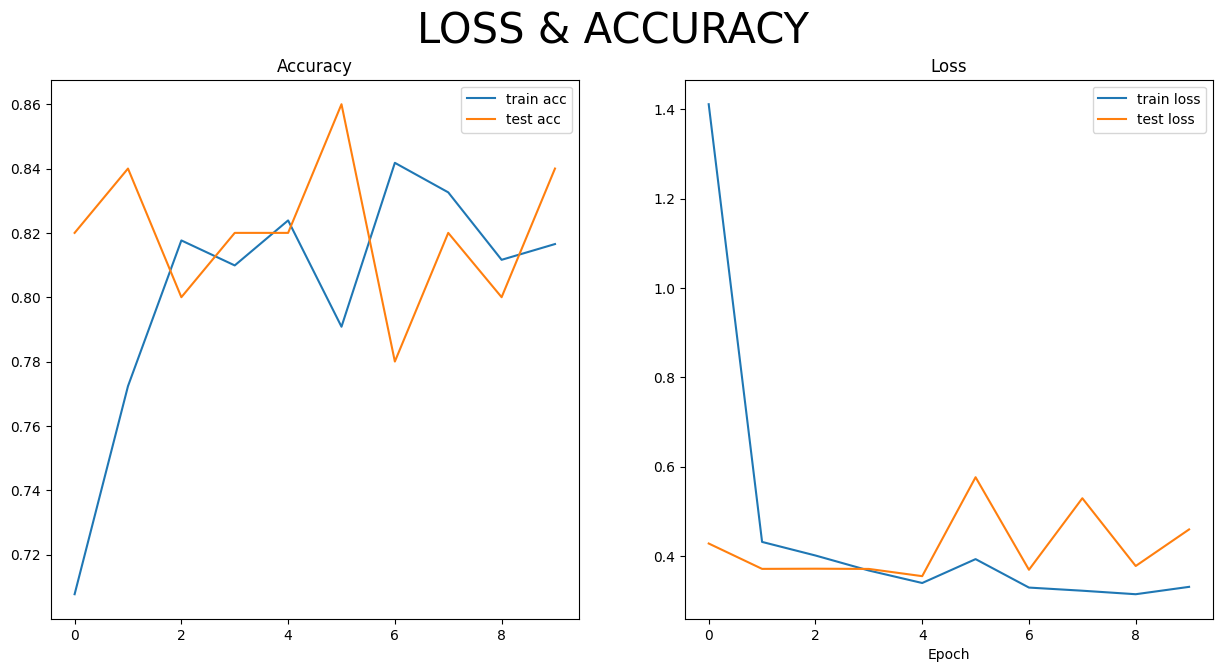

In [113]:
trainacc = model_results['train_acc']
testacc = model_results['test_acc']
trainloss = model_results['train_loss']
testloss = model_results['test_loss']
epoch = range(len(model_results['train_loss']))

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,7))

#fig = make_subplots(rows = 1, cols = 2, subplot_titles = ["accuracy", "loss"])
ax1.plot(epoch, trainacc,label = 'train acc')
ax1.plot(epoch, testacc, label = 'test acc')
ax1.set_title("Accuracy")
ax1.legend()

ax2.plot(epoch, trainloss, label='train loss')
ax2.plot(epoch, testloss, label = 'test loss')
ax2.set_title("Loss")
ax2.legend()
plt.xlabel("Epoch")

fig.suptitle('LOSS & ACCURACY', fontsize=30)

## Prediction on random Image

In [80]:
def predict_image(data_path, transforms, class_names):
    image = Image.open(data_path)
    image_trans = transforms(image).to(DEVICE).unsqueeze(dim = 0)
    
    y_logits = model(image_trans)
    y_preds = torch.softmax(y_logits, dim = 1)
    y_preb_probs = torch.argmax(y_preds, dim = 1)  # not used anyway
    
    
    fig,ax = plt.subplots(1,2)
    fig.tight_layout(pad=6)
    ax[0].imshow(image)
    ax[0].set_title('Image')
    x=y_preds.cpu().detach().numpy()[0] * 100
    y=class_names
    ax[1].barh(y,x)

    fig.suptitle("Predict function for Inception V3")
    plt.xlabel("Confidence")
    plt.ylabel("Classes")

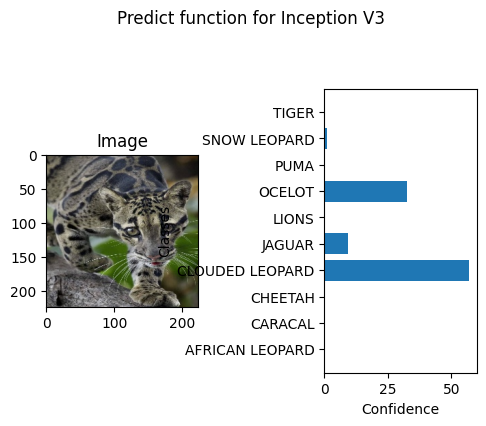

In [81]:
predict_image("tiger_dataset/valid/CLOUDED LEOPARD/5.jpg", simple_transform, train_data.classes)

## Accuracy on Validation Dataset

In [34]:
eval_loader

In [35]:
def val_model(model: torch.nn.Module, 
              loader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    val_loss, val_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (data, targets) in enumerate(loader):
            # Send data to target device
            data, targets = data.to(device), targets.to(device)
    
            # 1. Forward pass
            output_logits = model(data)

            # 2. Calculate and accumulate loss
            loss = loss_fn(output_logits, targets)
            val_loss += loss.item()
            
            # Calculate and accumulate accuracy
            output_labels = output_logits.argmax(dim=1)
            val_acc += ((output_labels == targets).sum().item()/len(output_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    val_loss = val_loss / len(loader)
    val_acc = val_acc / len(loader)
    return val_loss, val_acc

In [40]:
lossvalidation,accvalidation = val_model(model,eval_loader,loss_fn)

In [41]:
print(f"Accuarcy of EfficientNet custom Model on validation dataset: {accvalidation}")
print(f"Loss of EfficientNet Custom model on validation dataset: {lossvalidation}")

Accuarcy of EfficientNet custom Model on validation dataset: 0.9
Loss of EfficientNet Custom model on validation dataset: 0.1566009372472763


### Confusion Metrics and other Metrics

In [ ]:
class_names = train_data.classes

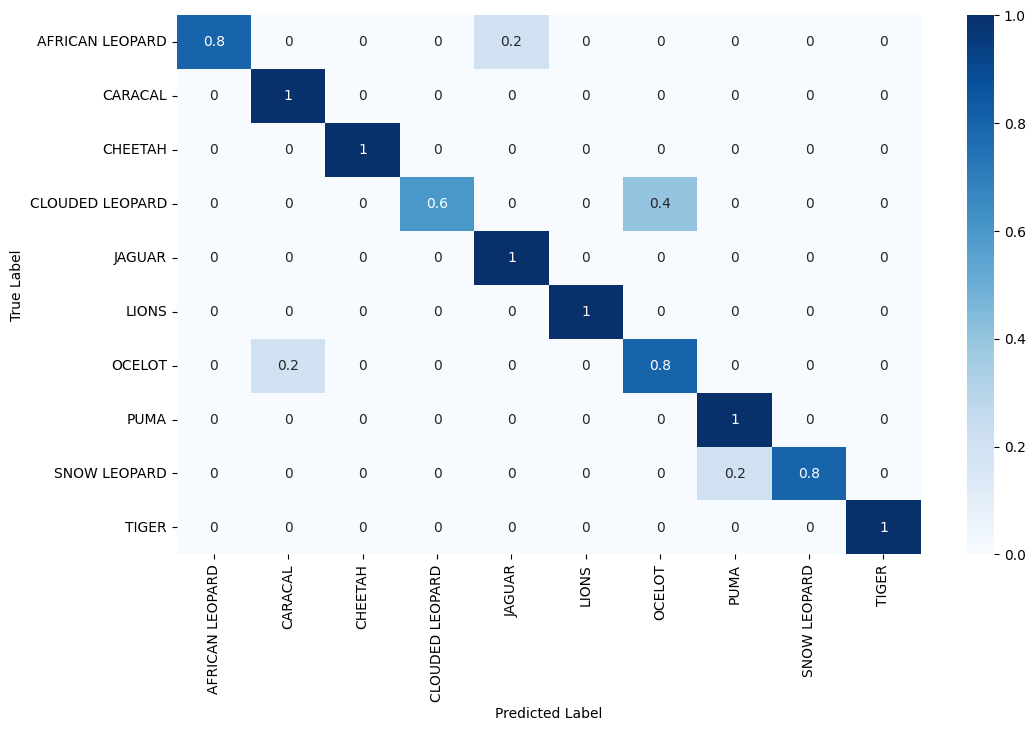

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model.eval()
# iterate over test data
with torch.inference_mode():
    for batch,(inputs, labels) in enumerate(eval_loader):
        
        #inputs, labels = inputs.to(DEVICE),labels.to(DEVICE)
        output = model(inputs) # Feed Network

        output = torch.argmax(output, dim=1).cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in class_names],
                     columns = [i for i in class_names])
plt.figure(figsize = (12,7))
s = sn.heatmap(df_cm, annot=True,cmap="Blues")
s.set(xlabel='Predicted Label', ylabel='True Label')
plt.savefig('cmatrixInception.png')

## Saving Model

In [118]:
SAVE_DIR = 'Best_model/Inception'

In [119]:
import os

if os.path.exists(SAVE_DIR):
    print('path Found')
else:
    os.mkdir(SAVE_DIR)

In [128]:
model_path = os.path.join(SAVE_DIR, "Inception_catClassifier"+".pth")
torch.save(model.state_dict(), model_path)